In [77]:
from IPython.core.display import HTML
HTML("<style>.container { width:90% !important; }</style>")

In [78]:
%matplotlib inline

In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from importlib import reload

In [80]:
import lnPi
reload(lnPi)

<module 'lnPi' from '/Users/wpk/Documents/python/lnPi/__init__.py'>

In [81]:
def tag_phases_binary(x):
    if x.base.num_phases_max != 2:
        raise ValueError('bad tag function')

    L = []
    for p in x.phases:
        if p.molfrac[0] < 0.5:
            val = 0
        else:
            val = 1
        L.append(val)

    return np.array(L)



In [82]:
base = lnPi.Base.from_table('./nahs_asym_mix.07_07_07.r1.lnpi_o.dat',mu=[0.5,0.5],fill_value=np.nan,zeromax=True,num_phases_max=2,beta=1.0, volume=1.0, pad=True)
lnpi_ref = lnPi.Phases(base, build_kwargs=dict(num_phases_max=5),ftag_phases=tag_phases_binary)

In [83]:
def get_spin_bin(ref,mu_in,x,spin_kwargs=None,bin_kwargs=None):
    
    if spin_kwargs is None: spin_kwargs={}
    if bin_kwargs is None: bin_kwargs = {}
    
    #initial estimate
    C = lnPi.Collection.from_mu(ref,mu_in,x)
    
    C.get_spinodals(**spin_kwargs)
    C.get_binodals(**bin_kwargs)
    
    return C
            

In [84]:
from tqdm import tqdm_notebook as tqdm

In [91]:
C = get_spin_bin(lnpi_ref,[None, -2.0], np.linspace(-10, 10, 2), spin_kwargs=dict(ntry=40, nmax=40))

In [96]:
C.omega_phase()

<xarray.DataArray 'omega' (rec: 5, phase: 2)>
array([[ -849.415114,          nan],
       [         nan, -3938.921554],
       [ -853.308157, -1008.579476],
       [ -850.174258,  -751.853707],
       [ -850.767468,  -850.767468]])
Coordinates:
  * phase    (phase) int64 0 1
    mu_0     (rec) float64 -10.0 10.0 -1.737 -3.011 -2.494
    mu_1     (rec) float64 -2.0 -2.0 -2.0 -2.0 -2.0
    beta     (rec) float64 1.0 1.0 1.0 1.0 1.0
    volume   (rec) float64 1.0 1.0 1.0 1.0 1.0
Dimensions without coordinates: rec

In [102]:
C.chempot_phase

AttributeError: 'Collection' object has no attribute 'chempot_phase'

In [100]:
C[2].chempot

<xarray.DataArray 'chempot' (phase: 2, component: 2)>
array([[-1.736514, -2.      ],
       [-1.736514, -2.      ]])
Coordinates:
    mu_0     float64 -1.737
    mu_1     float64 -2.0
    beta     float64 1.0
    volume   float64 1.0
Dimensions without coordinates: phase, component

In [94]:
C.has_phaseIDs

array([[ True, False],
       [False,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True]])

In [69]:
L=[]
for mu2 in tqdm(np.arange(-5,6,0.2),leave=True):
    try:
        C = get_spin_bin(lnpi_ref,[None,mu2],np.linspace(-10,10,2),spin_kwargs=dict(ntry=40,nmax=40))
    except:
        print('error at mu2',mu2)
        break
    L.append(C)

In [70]:
# write
da_labels = xr.concat([x.to_dataarray() for x in L if len(x)==5], dim='sample', coords='all')

da_labels.to_netcdf('tmp.nc', encoding={'labels': {'zlib': True, 'complevel':5}})

In [71]:
# read
with xr.open_dataarray('tmp.nc') as da_labels2:
    lst = []
    for i, g in da_labels2.groupby('sample'):
        lst.append(lnPi.Collection.from_dataarray(base, g))
    


In [72]:
spin_0 = lnPi.Collection([x.spinodals[0] for x in lst])
spin_1 = lnPi.Collection([x.spinodals[1] for x in lst])
bino   = lnPi.Collection([x.binodals[0] for x in lst])

In [75]:
s = lst[0].spinodals[0]

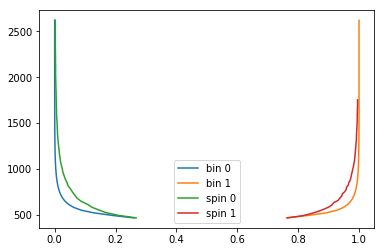

In [76]:
for phase in range(2):
    ds = xr.merge((bino.molfrac_phase, bino.omega_phase())).sel(phase=phase, component=0)
    plt.plot(ds.molfrac, -ds.omega, label='bin {}'.format(phase))
    
for phase, spin in enumerate([spin_0, spin_1]):
    ds = xr.merge((spin.molfrac_phase, spin.omega_phase())).sel(phase=phase, component=0)
    plt.plot(ds.molfrac, -ds.omega, label='spin {}'.format(phase))
    
plt.legend()